# Bias Buccaneers Image Recognition Challenge: Quickstart

This notebook will introduce you to the data and describe a workflow to train and evaluate a baseline model on it.

## Initial Setup

We start with loading the required packages.

In [1]:
# !pip install tensorflow
import numpy as np
import pandas as pd
import json
import os

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

import tensorflow as tf
import tensorflow.keras as K
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import ResNet50

## Load the Data

Make sure to download and uncompress the data (`data_bb1_img_recognition.zip`) in the folder you're working off of.

We first load the file containing the labels, binarize labels of each of the three classes as a numpy array and store them as a list.

In [2]:
# load data
LOADPATH = './train/'
SAVEPATH = './models/limited/'
df = pd.read_csv(LOADPATH+'labels.csv')
df_labeled = df[df["skin_tone"].notna()] # take only labeled data

# filter for verified humans
df_labeled = df_labeled[df_labeled['real_face'] == 1]

# Converting labels to np array
cat = ['skin_tone','gender','age']
lbs = [LabelBinarizer() for i in range(3)]
base_Y = []
for i in range(3):
    lab = lbs[i].fit_transform(df_labeled[cat[i]])
    if lab.shape[1]==1:
        base_Y.append(np.hstack((1-lab,lab)))
    else:
        base_Y.append(lab)

We then load the images under the training set and convert them to numpy arrays. This may take a while.

In [3]:
# loading and converting data into np array
print("Loading images")
length = width = 64 # size for each input image, increase if you want
base_nn = df_labeled.shape[0]
all_imgs = [image.load_img(LOADPATH+df_labeled.iloc[i]['name'], target_size=(length,width)) for i in range(base_nn)]

print("Converting images to np array")
base_X = np.empty([base_nn, length, width, 3], dtype=float)
for i in range(base_nn):
    base_X[i,:] = image.img_to_array(all_imgs[i])
base_X = K.applications.resnet50.preprocess_input(base_X)

Loading images
Converting images to np array


In [14]:
# Converting to triplicate to match with the different augmentations
base_X = [base_X, base_X, base_X]

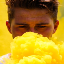

In [4]:
all_imgs[1235] # print a test image

### Augment the data

In [5]:
import imgaug.augmenters as iaa
from pathlib import Path
import cv2
from IPython.display import Image


In [6]:
newseq = iaa.Sequential([
    iaa.Fliplr(0.5), # horizontal flips
    
    # Small gaussian blur with random sigma between 0 and 0.5.
    # But we only blur about 50% of all images.
    iaa.Sometimes(
        0.5,
        iaa.GaussianBlur(sigma=(0, 0.5))
    ),
    
    # Strengthen or weaken the contrast in each image.
    iaa.LinearContrast((0.75, 1.5)),
   
    # Make some images brighter and some darker.
    # In 20% of all cases, we sample the multiplier once per channel,
    # which can end up changing the color of the images.
    iaa.Multiply((0.8, 1.2), per_channel=0.0),
    
    # Apply affine transformations to each image.
    # Scale/zoom them, translate/move them, rotate them and shear them.
    iaa.Affine(
        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
        rotate=(-15, 15),
        shear=(-8, 8)
    )
], random_order=True)

In [7]:
def create_aug_names(names: pd.Series, cat: str) -> pd.Series:
    augnames = names.copy()
    for i, name in enumerate(names.values):
        augnames.iloc[i] = "AUG_" + cat + "_" + str(i) + "_" + name
    return augnames


In [8]:
def get_imgs_to_sample(series: pd.Series) -> pd.Series:
    counts = series.value_counts()
    return counts.max() - counts

In [9]:
def create_augs(df: pd.DataFrame, img_to_sample: pd.Series, seq: iaa.Sequential, read_dir, write_dir, colname: str = "age") -> pd.DataFrame:
    new_df = pd.DataFrame()
    for cat, count in img_to_sample.items():
        print(f"Sampling {count} images for {colname} {cat}")
        if count > 0:
            df_sample = df[df[colname] == cat].sample(count, replace=True)
            df_sample["aug_name"] = create_aug_names(df_sample["name"], cat)
            df_sample["aug_cat"] = colname
            sample_imgs = [cv2.imread(read_dir + '/' + name) for name in df_sample["name"]]
            augs = seq.augment_images(sample_imgs)
            for i, aug in enumerate(augs):
                cv2.imwrite(str(write_dir + '/' + df_sample.iloc[i, 5]), aug)
            new_df = pd.concat([new_df, df_sample])
    return new_df


In [10]:
def upsample_imgs(df, sample_cols, seq, read_dir, write_dir):
    aug_df = pd.DataFrame()
    for col in sample_cols:
        print(f"Upsampling {col}")
        counts = df[col].value_counts()
        img_to_sample = counts.max() - counts
        aug_df = pd.concat(
            [
                aug_df,
                create_augs(df, img_to_sample, seq=seq, colname=col, read_dir=read_dir, write_dir=write_dir),
            ]
        )
    return aug_df

In [11]:
labels = pd.read_csv('./train/labels.csv')
labels = labels[labels["real_face"] == 1].dropna()
aug_df = upsample_imgs(labels, sample_cols=cat, seq=newseq, read_dir='./train', write_dir='./augmented_train')

Upsampling skin_tone
Sampling 0 images for skin_tone monk_3
Sampling 23 images for skin_tone monk_4
Sampling 59 images for skin_tone monk_5
Sampling 83 images for skin_tone monk_2
Sampling 209 images for skin_tone monk_7
Sampling 220 images for skin_tone monk_6
Sampling 261 images for skin_tone monk_8
Sampling 261 images for skin_tone monk_1
Sampling 301 images for skin_tone monk_9
Sampling 326 images for skin_tone monk_10
Upsampling gender
Sampling 0 images for gender female
Sampling 373 images for gender male
Upsampling age
Sampling 0 images for age 18_30
Sampling 445 images for age 31_60
Sampling 515 images for age 0_17
Sampling 855 images for age 61_100


In [12]:
aug_df.to_csv('./augmented_train/labels.csv')

### Integrate the Augmented Data

In [13]:
# load data
AUGPATH = './augmented_train/'
aug_df = pd.read_csv(AUGPATH+'labels.csv')
df_aug_labeled = aug_df[aug_df["skin_tone"].notna()] # take only labeled data

# Converting labels to np array
aug_Y = []
for i in range(3):
    lab = lbs[i].transform(df_aug_labeled[df_aug_labeled['aug_cat']==cat[i]][cat[i]])
    if lab.shape[1]==1:
        aug_Y.append(np.hstack((1-lab,lab)))
    else:
        aug_Y.append(lab)

# NEED TO MAKE X DEAL WITH DIFFERENT SETS OF DATA PER CATEGORY

In [20]:
# loading and converting data into np array
print("Loading images")
length = width = 64 # size for each input image, increase if you want
aug_nn = [0,0,0]
aug_X = [[],[],[]]

for i in range(3):
    aug_nn[i] = df_aug_labeled[df_aug_labeled['aug_cat']==cat[i]].shape[0]
    imgs = [image.load_img(AUGPATH+df_aug_labeled[df_aug_labeled['aug_cat']==cat[i]].iloc[j]['aug_name'], target_size=(length,width)) for j in range(aug_nn[i])]

    print("Converting images to np array")
    aug_X[i] = np.empty([aug_nn[i], length, width, 3], dtype=float)
    for j in range(aug_nn[i]):
        aug_X[i][j,:] = image.img_to_array(imgs[j])
    aug_X[i] = K.applications.resnet50.preprocess_input(aug_X[i])

Loading images
Converting images to np array
Converting images to np array
Converting images to np array


In [25]:
Y = [[],[],[]]
X = [[],[],[]]

for i in range(len(cat)):
    Y[i] = np.concatenate([base_Y[i], aug_Y[i]])
    X[i] = np.concatenate([base_X[i], aug_X[i]])

nn = base_nn+np.array(aug_nn)

In [27]:
X[0].shape

(3580, 64, 64, 3)

In [28]:
Y[0].sum(axis=0)

array([358, 358, 358, 358, 358, 358, 358, 358, 358, 358])

## Specify the Model

We define a single model class that is able train on the data in `X` and `Y` and predict outcomes for all three classes.

In [44]:
class PredictionModel():
    def __init__(self, X, Y, idx):
        self.X = X
        self.Y = Y
        self.idx = idx
        self.trainX, self.testX = [X[i][idx[0][i],:] for i in range(3)], [X[i][idx[1][i],:] for i in range(3)]
        self.trainY, self.testY = [Y[i][idx[0][i],:] for i in range(3)], [Y[i][idx[1][i],:] for i in range(3)]
        self.cat = ['skin_tone','gender','age']
        self.loss = ['categorical_crossentropy' for i in range(3)]
        self.metrics = [['accuracy'] for i in range(3)]
        self.models = [None]*3

    # train a model specific for a certain class index in self.cat
    def fit(self, index, model, epochs=5, batch_size=32, save=False, save_location=None, verbose=1):
        
        if verbose: print("Training model for "+self.cat[index])
        
        model.add(K.layers.Dense(self.trainY[index].shape[1], activation='softmax'))
        model.compile(loss=self.loss[index], optimizer='Adam', metrics=self.metrics[index])
        model.fit(
            self.trainX[index], self.trainY[index], 
            validation_data=(self.testX[index],self.testY[index]), 
            batch_size=batch_size, epochs=epochs, verbose=verbose
        )
        
        if save:
            if os.path.exists(SAVEPATH)==False:
                print('save location '+SAVEPATH+' did not exist. creating')
                os.makedirs(SAVEPATH)
            SAVE_LOCATION = save_location+'model_'+cat[index]+'.h5'
            print("saving model at "+SAVE_LOCATION)
            model.save(SAVE_LOCATION)
        
        self.models[index] = model
        
    # train a model which updates loss weights after each epoch
    def custom_fit(self, index, model, epochs=5, batch_size=32, save=False, save_location=None, verbose=1):
        
        if verbose: print("Training custom weight model for "+self.cat[index])
        
        output_categories = self.trainY[index].shape[1]
        counts = self.trainY[index].sum(axis=0)
        
        model.add(K.layers.Dense(output_categories, activation='softmax'))
        
        loss_weights = np.ones(output_categories)/output_categories
        loss_weights = (loss_weights / counts) / np.sum(loss_weights / counts)
        opt = tf.keras.optimizers.Adam(0.001)
        
        for i in range(epochs):
            print(f"Epoch {i+1}/{epochs}")
            model.compile(loss=self.loss[index], loss_weights = loss_weights, optimizer=opt, metrics=self.metrics[index])
        
            model.fit(
                self.trainX[index], self.trainY[index], 
                validation_data=(self.testX[index],self.testY[index]), 
                batch_size=batch_size, epochs=1, verbose=verbose
            )

            predy = np.argmax(model.predict(self.testX[index]),1)
            truey = np.argmax(self.testY[index],1)
            cats = max(truey) + 1
            accs = np.zeros(cats)
            for i in range(cats):
                accs[i] = np.sum((predy==truey) & (truey==i))/np.sum(truey==i)
            ds = max(accs) - min(accs)
            epsilon = .001
            
            loss_weights = (1 - accs)
            loss_weights = (loss_weights / counts) / np.sum(loss_weights / counts)
            print(accs)
            print(ds)
            print(loss_weights)
            
        if save:
            if os.path.exists(SAVEPATH)==False:
                print('save location '+SAVEPATH+' did not exist. creating')
                os.makedirs(SAVEPATH)
            SAVE_LOCATION = save_location+'custommodel_'+cat[index]+'.h5'
            print("saving model at "+SAVE_LOCATION)
            model.save(SAVE_LOCATION)
        
        self.models[index] = model
            
    def predict(self, newX):
        predictions = [model.predict(newX) for model in self.models]
        return predictions

## Initialize and Train a Model

We now train a `PredictionModel` to predict the likely skin tone, gender, and age of an input image. This baseline model is initialize on imagenet weights and uses the ResNet50 architecture. We strongly recommend using a GPU to reduce training time.

In [39]:
# function to initialize a model
def initializeModel():
    res_model = ResNet50(include_top=False, weights='imagenet', input_tensor=K.Input(shape=[length,width,3]))

    # freeze all but the last layer
    for layer in res_model.layers[:143]:
        layer.trainable = False
    model = K.models.Sequential()
    model.add(res_model)
    model.add(K.layers.Flatten())
    model.add(K.layers.BatchNormalization())
    model.add(K.layers.Dense(256, activation='relu'))
    model.add(K.layers.Dropout(0.5))
    model.add(K.layers.BatchNormalization())
    model.add(K.layers.Dense(128, activation='relu'))
    model.add(K.layers.Dropout(0.5))
    model.add(K.layers.BatchNormalization())
    model.add(K.layers.Dense(64, activation='relu'))
    model.add(K.layers.Dropout(0.5))
    model.add(K.layers.BatchNormalization())
    return model

nntrain = [[],[],[]]
indices = [[],[],[]]
train_idx = [[],[],[]]
test_idx = [[],[],[]]

for i in range(3):
    nntrain[i] = int(0.7*nn[i])
    np.random.seed(42)
    indices = np.random.permutation(nn[i])
    train_idx[i], test_idx[i] = indices[:nntrain[i]], indices[nntrain[i]:]



In [45]:
mymodel = PredictionModel(X=X, Y=Y, idx=[train_idx,test_idx])


In [46]:
# train model
for i in range(3):
    mymodel.fit(index=i, model=initializeModel(), epochs=5, save=True, save_location='./models/balanced/')

Training model for skin_tone
Epoch 1/5
79/79 [==============================] - 65s 722ms/step - loss: 2.7729 - accuracy: 0.1233 - val_loss: 17.7663 - val_accuracy: 0.0950
Epoch 2/5
79/79 [==============================] - 59s 748ms/step - loss: 2.5887 - accuracy: 0.1285 - val_loss: 3.9159 - val_accuracy: 0.1834
Epoch 3/5
79/79 [==============================] - 56s 709ms/step - loss: 2.4159 - accuracy: 0.1544 - val_loss: 2.5827 - val_accuracy: 0.2328
Epoch 4/5
79/79 [==============================] - 60s 765ms/step - loss: 2.3064 - accuracy: 0.1652 - val_loss: 2.0023 - val_accuracy: 0.2840
Epoch 5/5
79/79 [==============================] - 58s 738ms/step - loss: 2.1675 - accuracy: 0.1919 - val_loss: 1.9112 - val_accuracy: 0.2812
saving model at ./models/balanced/model_skin_tone.h5
Training model for gender
Epoch 1/5
49/49 [==============================] - 46s 787ms/step - loss: 0.8124 - accuracy: 0.6012 - val_loss: 18.4387 - val_accuracy: 0.5415
Epoch 2/5
49/49 [=====================

## Evaluate the Model

We now evaluate the model on the test data. To do this, let's first load up that data and structure it similarly.

In [47]:
# load labels data
TESTPATH = './test/'
df_test = pd.read_csv(TESTPATH+'labels.csv')

# Convert labels to np array
print("Converting test labels to np array")
testY = []
for i in range(3):
    lab = lbs[i].fit_transform(df_test[cat[i]])
    if lab.shape[1]==1:
        testY.append(np.hstack((1-lab,lab)))
    else:
        testY.append(lab)
        
# load and convert images into np array
print("Loading test images")
nt = df_test.shape[0]
all_imgs = [image.load_img(TESTPATH+df_test.iloc[i]['name'], target_size=(length,width)) for i in range(nt)]

print("Converting test images to np array")
testX = np.empty([nt, length, width, 3], dtype=float)
for i in range(nt):
    testX[i,:] = image.img_to_array(all_imgs[i])
testX = K.applications.resnet50.preprocess_input(testX)

Converting test labels to np array
Loading test images
Converting test images to np array


We also need to reload the model:

In [ ]:
#index = 1
#test_mod = K.models.load_model(SAVEPATH+'model_'+cat[index]+'.h5')
#test_mod.compile(loss_weights = [.5,.5])
#test_mod.predict(testX)

We then obtain predicted labels for skin tone, gender, and age as a list of lists.

In [48]:
pred = mymodel.predict(testX)
predY = [[np.argmax(pred[i][j,:]) for j in range(nt)] for i in range(3)]
predLabels = [[lbs[i].classes_[j] for j in predY[i]] for i in range(3)]

94/94 [==============================] - 17s 166ms/step


Finally, we calculate the label-wise accuracy and disparity.

In [49]:
# calculate accuracy
acc = {}
for i in range(3):
    icat = cat[i]
    iacc = accuracy_score(df_test[cat[i]], predLabels[i])
    acc[icat] = iacc

# calculate disparity
def disparity_score(ytrue, ypred):
    cm = confusion_matrix(ytrue,ypred)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    all_acc = list(cm.diagonal())
    return max(all_acc) - min(all_acc)

disp = {}
for i in range(3):
    icat = cat[i]
    idisp = disparity_score(df_test[cat[i]], predLabels[i])
    disp[icat] = idisp
disp

results = {'accuracy': acc, 'disparity': disp}
results

{'accuracy': {'skin_tone': 0.18666666666666668,
  'gender': 0.7616666666666667,
  'age': 0.5433333333333333},
 'disparity': {'skin_tone': 0.4982980743697242,
  'gender': 0.18492171426578796,
  'age': 0.35663206459054214}}

skin_tone


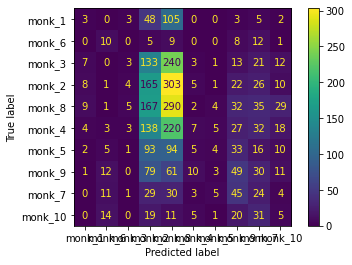

gender


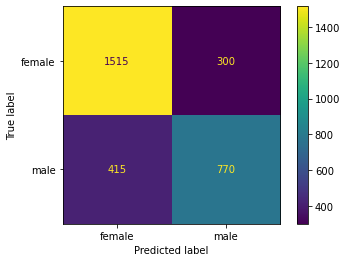

age


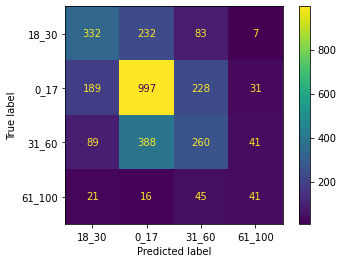

In [50]:
import matplotlib.pyplot as plt

for i in range(3):
    labels = df[df[cat[i]].notna()][cat[i]].unique()
    print(cat[i])
    ConfusionMatrixDisplay(confusion_matrix(df_test[cat[i]], predLabels[i]),display_labels=labels).plot()
    plt.show()

# Score Model and Prepare Submission

Based on the above metric, we now calculate the score to evaluate your submission. This score will be displayed in your public leaderboard.

In [51]:
def getScore(results):
    acc = results['accuracy']
    disp = results['disparity']
    ad = 2*acc['gender']*(1-disp['gender']) + 4*acc['age']*(1-disp['age']**2) + 10*acc['skin_tone']*(1-disp['skin_tone']**5)
    return ad

title = 'OII Crew'
    
submission = {
    'submission_name': title,
    'score': getScore(results),
    'metrics': results
}

   
submission

{'submission_name': 'OII Crew',
 'score': 4.947870136133126,
 'metrics': {'accuracy': {'skin_tone': 0.18666666666666668,
   'gender': 0.7616666666666667,
   'age': 0.5433333333333333},
  'disparity': {'skin_tone': 0.4982980743697242,
   'gender': 0.18492171426578796,
   'age': 0.35663206459054214}}}

Finally, let's export this as a json file to upload as part of filling out your [submission form](https://docs.google.com/forms/d/e/1FAIpQLSfwqtVkJBVRP6TnFp7vHbbH8SlwKZJFIjvGQy7TyYFc8HR1hw/viewform).

In [ ]:
clean_data

In [ ]:
with open("baseline_score.json", "w") as f:
    json.dump(submission, f, indent=4)